In [1]:
def clip(tmp1):
    import subprocess
    import shlex  # 导入 shlex 模块
    # 使用 shlex.quote 来转义 inp 字符串
    tmp2 = str(tmp1)
    safe_str = shlex.quote(tmp2)
    subprocess.run('echo {} | wclip'.format(safe_str), shell=True)  

def cvin(k):
    clip(In[k])
    
import numpy as np
import matplotlib.pyplot as plt

#格式化输出
np.set_printoptions(precision=3, suppress=True, linewidth=100)

### 1.马尔可夫过程
如果要用强化学习去解决一个实际问题，第一步要做的事情就是把这个实际问题抽象为一个马尔可夫决策过程

#### 随机过程
指某时刻t取值用向量表示$S_{t}$，而该状态取决于t时刻之前的状态，记作$P(S_{t+1}|S_{1},\ldots ,S_{t})$

#### 马尔可夫性质
当且仅当某时刻的状态只取决于上一时刻的状态时，一个随机过程被称为具有马尔可夫性质，记作$P(S_{t+1}|S_{t})= P(S_{t+1}|S_{1},\ldots ,S_{t})$——下一个状态完全取决于当前状态，通过这种链式关系，可以大大简化运算(因为不需要知道所有历史信息)

#### 马尔可夫过程
马尔可夫过程 (Markov process) 指具有马尔可夫性质的随机过程，也被称为马尔可夫链 (Markov chain) 。我们通常用元组 $\langle\mathcal{S}, \mathcal{P}\rangle$ 描述一个马尔可夫过程，其中 $\mathcal{S}$ 是有限数量的状态集合， $\mathcal{P}$ 是状态转移矩 阵 (state transition matrix) 。假设一共有 n 个状态，此时 $\mathcal{S}=\left\{s_{1}, s_{2}, \ldots, s_{n}\right\}$ 。状态转移矩阵 $\mathcal{P}$ 定义了 所有状态对之间的转移概率，即:
$$
\\\\\mathcal{P}=\left[\begin{array}{ccc}\\P\left(s_{1} \mid s_{1}\right) & \cdots & P\left(s_{n} \mid s_{1}\right) \\\\\vdots & \ddots & \vdots \\\\P\left(s_{1} \mid s_{n}\right) & \cdots & P\left(s_{n} \mid s_{n}\right)\\\end{array}\right]\\\\
$$
矩阵 $\mathcal{P}$ 中第 i 行第 j 列元素 $P\left(s_{j} \mid s_{i}\right)=P\left(S_{t+1}=s_{j} \mid S_{t}=s_{i}\right)$ 表示从状态$ s_{i}$ 转移到状态 $s_{j}$ 的概率，我们称 $P\left(s^{\prime} \mid s\right)$ 为状态转移函数。从某个状态出发，到达其他状态的概率和必须为 1 ，即状态转移矩阵 $\mathcal{P}$ 的每一 行的和为 1 。

给定一个马尔可夫过程，我们就可以从某个状态出发，根据它的状态转移矩阵生成一个**状态序列（episode）**，这个步骤也被叫做**采样（sampling）**

### 2.马尔可夫奖励过程 MRP

在马尔可夫过程的基础上加入奖励函数 $r$ 和折扣因子 $\gamma$，就可以得到马尔可夫奖励过程（Markov reward process）。
一个马尔可夫奖励过程由 $ \langle\mathcal{S}, \mathcal{P}, r, \gamma\rangle $ 构成，各个组成元素的含义如下所示。
- $\mathcal{S}$ 是有限状态的集合
- $\mathcal{P}$ 是状态转移矩阵
- $r$ 是**奖励函数**，某个状态 $s$ 的奖励 $r(s)$ 指转移到该状态时可以获得奖励的期望
- $\gamma$ 是折扣因子 (discount factor)， $\gamma$ 的取值范围为 [0,1) 。

引入折扣因子的理由为远期利益具有一定不确定性，有时我们更希望能够尽快获得一些奖励，所以我们需要对远期利益打一些折扣。
- 接近 1 的 $\gamma$ 更关注长期的累计奖励
- 接近 0 的 $\gamma$ 更考虑短期奖励

#### 2.1回报
在一个马尔可夫奖励过程中，从第t时刻状态 $S_{t}$ 开始，直到终止状态时，所有奖励的衰减之和称为回报 $G_{t}$ (Return)， 公式如下：
$$
G_{t}=R_{t}+\gamma R_{t+1}+\gamma^{2} R_{t+2}+\cdots=\sum_{k=0}^{\infty} \gamma^{k} R_{t+k} 
$$


In [2]:
import numpy as np
np.random.seed(0)
# 定义状态转移概率矩阵P
P = [
    [0.9, 0.1, 0.0, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.6, 0.0, 0.4],
    [0.0, 0.0, 0.0, 0.0, 0.3, 0.7],
    [0.0, 0.2, 0.3, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
]
P = np.array(P)

rewards = [-1, -2, -2, 10, 1, 0]  # 定义奖励函数
gamma = 0.5  # 定义折扣因子

In [3]:
# 给定一条序列,计算从某个索引（起始状态）开始到序列最后（终止状态）得到的回报
def compute_return(start_index, chain, gamma):
    G = 0
    for i in reversed(range(start_index, len(chain))):
        G = gamma * G + rewards[chain[i] - 1]
    return G

In [4]:
# 一个状态序列,s1-s2-s3-s6
chain = [1, 2, 3, 6]
start_index = 0
G = compute_return(start_index, chain, gamma)
print("根据本序列计算得到回报为：%s。" % G)

根据本序列计算得到回报为：-2.5。


#### 2.2价值函数V(s)
在马尔可夫奖励过程中，一个状态的期望回报（即从这个状态出发的未来累积奖励的期望）被称为这个状态的**价值（value）**。所有状态的价值就组成了**价值函数（value function）**，价值函数的输入为某个状态，输出为这个状态的价值：

$V(s) = \mathbb{E}\left[G_{t} \mid S_{t}=s\right]$

$= \mathbb{E}\left[R_{t}+\gamma R_{t+1}+\gamma^{2} R_{t+2}+\ldots \mid S_{t}=s\right]$

$= \mathbb{E}\left[R_{t}+\gamma\left(R_{t+1}+\gamma R_{t+2}+\ldots\right) \mid S_{t}=s\right]$

$= \mathbb{E}\left[R_{t}+\gamma G_{t+1} \mid S_{t}=s\right]$

$= \mathbb{E}\left[R_{t}+\gamma V\left(S_{t+1}\right) \mid S_{t}=s\right]$

在上式的最后一个等号中，一方面，即时奖励的期望正是奖励函数的输出，即 $\mathbb{E}\left[R_{t} \mid S_{t}=s\right]=r(s)$；
另一方面，等式中剩余部分 $\mathbb{E}\left[\gamma V\left(S_{t+1}\right) \mid S_{t}=s\right]$ 可以根据从状态 $s$ 出发的转移概率得到，即可以得到:
$$
V(s)=r(s)+\gamma \sum_{s^{\prime} \in S} p\left(s^{\prime} \mid s\right) V\left(s^{\prime}\right)
$$
上式就是马尔可夫奖励过程中非常有名的**贝尔曼方程（Bellman equation）**，对每一个状态都成立。若一个马尔可夫奖励过程一共有 $n$ 个状态，即 $\mathcal{S}=\left\{s_{1}, s_{2}, \ldots, s_{n}\right\}$，我们将所有状态的价值表示成一个列向量 $\mathcal{V}=\left[V\left(s_{1}\right), V\left(s_{2}\right), \ldots, V\left(s_{n}\right)\right]^{T}$，同理，将奖励函数写成一个列向量
$\mathcal{R}=\left[r\left(s_{1}\right), r\left(s_{2}\right), \ldots, r\left(s_{n}\right)\right]^{T}$。于是我们可以将贝尔曼方程写成矩阵的形式:
$$
\mathcal{V}=\mathcal{R}+\gamma \mathcal{P} \mathcal{V}
$$
$$
{\left[\begin{array}{c}
V\left(s_{1}\right) \\
V\left(s_{2}\right) \\
\ldots \\
V\left(s_{n}\right)
\end{array}\right]=\left[\begin{array}{c}
r\left(s_{1}\right) \\
r\left(s_{2}\right) \\
\ldots \\
r\left(s_{n}\right)
\end{array}\right]+\gamma\left[\begin{array}{cccc}
P\left(s_{1} \mid s_{1}\right) & p\left(s_{2} \mid s_{1}\right) & \ldots & P\left(s_{n} \mid s_{1}\right) \\
P\left(s_{1} \mid s_{2}\right) & P\left(s_{2} \mid s_{2}\right) & \ldots & P\left(s_{n} \mid s_{2}\right) \\
\ldots & & & \\
P\left(s_{1} \mid s_{n}\right) & P\left(s_{2} \mid s_{n}\right) & \ldots & P\left(s_{n} \mid s_{n}\right)
\end{array}\right]\left[\begin{array}{c}
V\left(s_{1}\right) \\
V\left(s_{2}\right) \\
\ldots \\
V\left(s_{n}\right)
\end{array}\right]}
$$
我们可以直接根据矩阵运算求解，得到以下解析解:

$\mathcal{V} =\mathcal{R}+\gamma \mathcal{P} \mathcal{V}$
$(I-\gamma \mathcal{P}) \mathcal{V} =\mathcal{R}$
$\mathcal{V} =(I-\gamma \mathcal{P})^{-1} \mathcal{R}$

以上解析解的计算复杂度是 $O\left(n^{3}\right)$，其中 $n$ 是状态个数，因此这种方法只适用很小的马尔可夫奖励过程。
求解较大规模的马尔可夫奖励过程中的价值函数时，可以使用**动态规划（dynamic programming算法**、**蒙特卡洛方法（Monte-Carlo method）**和**时序差分（temporal difference）**

In [5]:
def compute(P, rewards, gamma, states_num):
    ''' 利用贝尔曼方程的矩阵形式计算解析解,states_num是MRP的状态数 '''
    rewards = np.array(rewards).reshape((-1, 1))  #将rewards写成列向量形式
    value = np.dot(np.linalg.inv(np.eye(states_num, states_num) - gamma * P),
                   rewards)
    return value


V = compute(P, rewards, gamma, 6)
print("MRP中每个状态价值分别为\n", V)

MRP中每个状态价值分别为
 [[-2.02 ]
 [-2.215]
 [ 1.161]
 [10.538]
 [ 3.587]
 [ 0.   ]]


可以用贝尔曼方程进行验证：
$$
V(s_{4})=r(s_{4})+\gamma \sum_{s^{\prime} \in S} p\left(s^{\prime} \mid s_{4}\right) V\left(s^{\prime}\right)
$$
$10.54 = 10 + 0.5 \times (0.7 \times 0+0.3 \times 3.59)$

---

### 3.马尔可夫决策过程 MDP
马尔可夫过程和马尔可夫奖励过程都是自发改变的随机过程；而如果有一个外界的"刺激"来共同改变这个随机过程，就有了**马尔可夫决策过程（Markov decision process，MDP）**
将这个来自外界的刺激称为**智能体/代理（agent）**的动作，一个马尔科夫决策过程由元组$ \langle\mathcal{S}, \mathcal{A}, \mathcal{P}, r, \gamma\rangle $构成
- $\mathcal{S}$ 状态集合
- $\mathcal{A}$->新增 动作集合
- $\mathcal{P}$->$P(s^{\prime} | s,a)$ 是**状态转移函数**，表示在状态s执行a后到达$s^{\prime}$的概率(可以为1)
- $r$ -> $r(s,a)$ 是**奖励函数**,此时的奖励同时取决于状态s和下一步动作a，可以退化为$r(s)$
- $\gamma$ 是折扣因子

MDP 与 MRP 非常相像，只是多了动作$a$作为自变量
**_注意：不再使用MRP的状态转移矩阵，而是直接使用状态转移函数，可以处理非离散值_**

#### 3.1策略 $\pi$
智能体的策略（Policy）通常用$\pi$表示，写作$\pi(a | s)=P(A_{t}=a | S_{t} = s)$的形式，并细分为：
- **_确定性策略（deterministic policy）_** 每个状态时只输出一个确定性的动作，即只有该动作的概率为 1，其他动作的概率为 0
- **_随机性策略（stochastic policy）_** 每个状态时输出的是关于动作的概率分布

#### 3.2状态价值函数$V^{\pi}(s)$
<u>**_注意：此时的价值函数与策略有关——不同的策略下，同一个状态的价值是不同的->因为不同的策略会带来不同的动作，从而有不同的奖励_**</u>

我们用 $V^{\pi}(s)$ 表示在 MDP 中基于策略 $\pi$ 的**状态价值函数（state-value function）**，定义为从状态 $s$ 出发遵循策略 $\pi$ 能获得的期望回报，数学表达为:
$$
V^{\pi}(s)=\mathbb{E}_{\pi}\left[G_{t} \mid S_{t}=s\right]
$$

#### 3.3动作价值函数$Q^{\pi}(s,a)$
由于动作的存在额外定义一个**动作价值函数 (action-value function）**。我们用 $Q^{\pi}(s, a)$ 表示在 MDP 遵循策略 $\pi$ 时，对当前状态 $s$ 执行动作 $a$ 得到的期望回报:
$$
Q^{\pi}(s, a)=\mathbb{E}_{\pi}\left[G_{t} \mid S_{t}=s, A_{t}=a\right]
$$
1. **_状态价值函数和动作价值函数之间的关系：_** 在使用策略 $\pi$ 中，状态 $s$ 的价值等于在该状态下基于策略 $\pi$ 采取所有动作的概率与相应的价值相乘再求和的结果:
$$
V^{\pi}(s)=\sum_{a \in A} \pi(a \mid s) Q^{\pi}(s, a)
$$
2. **_使用策略 $\pi$ 时，状态 $s$ 下采取动作 $a$ 的价值:_** 等于即时奖励加上经过衰减后的所有可能的下一个状态的状态转移概率与相应的价值的乘积:
$$
Q^{\pi}(s, a)=r(s, a)+\gamma \sum_{s^{\prime} \in S} P\left(s^{\prime} \mid s, a\right) V^{\pi}\left(s^{\prime}\right)
$$

### 4.贝尔曼期望方程
> **价值函数和贝尔曼方程是强化学习非常重要的组成部分，之后的一些强化学习算法都是据此推导出来的，需要明确掌握！**

在贝尔曼方程中加上“期望”二字是为了与接下来的贝尔曼最优方程进行区分：
$$
\begin{aligned} V^{\pi}(s) & =\mathbb{E}_{\pi}\left[R_{t}+\gamma V^{\pi}\left(S_{t+1}\right) \mid S_{t}=s\right] \\ & =\sum_{a \in A} \pi(a \mid s)\left(r(s, a)+\gamma \sum_{s^{\prime} \in S} p\left(s^{\prime} \mid s, a\right) V^{\pi}\left(s^{\prime}\right)\right) \\ Q^{\pi}(s, a) & =\mathbb{E}_{\pi}\left[R_{t}+\gamma Q^{\pi}\left(S_{t+1}, A_{t+1}\right) \mid S_{t}=s, A_{t}=a\right] \\ & =r(s, a)+\gamma \sum_{s^{\prime} \in S} p\left(s^{\prime} \mid s, a\right) \sum_{a^{\prime} \in A} \pi\left(a^{\prime} \mid s^{\prime}\right) Q^{\pi}\left(s^{\prime}, a^{\prime}\right)\end{aligned}
$$
需要注意，并非在每个状态都能采取所有动作

#### 4.1MDP近似求解
直接为MDP找到解析解是计算密集型的，特别是当状态和动作空间很大时。在这种情况下，通常会使用近似方法或学习算法：
迭代方法用于求解MDP的最优策略。最常用的两种迭代方法是**值迭代**和**策略迭代**。下面是这两种方法的详细描述：

1. 值迭代 (Value Iteration)
值迭代是一种迭代算法，用于计算每个状态的最优值函数。该方法基于贝尔曼最优性方程，以下是算法步骤：
1. 初始化值函数，例如 $V(s) = 0$ 对于所有状态 $s$。
2. 迭代更新值函数直到收敛：
   $$V_{\text{new}}(s) = \max_{a \in A} \left( R(s,a) + \gamma \sum_{s' \in S} P(s'|s,a) V(s') \right)$$
3. 重复步骤2，直到 $V$ 的变化小于某个阈值或达到最大迭代次数。
4. 一旦值函数收敛，可以通过贪婪策略得到最优策略：
   $$\pi^*(s) = \arg\max_{a \in A} \left( R(s,a) + \gamma \sum_{s' \in S} P(s'|s,a) V^*(s') \right)$$

2. 策略迭代 (Policy Iteration)
策略迭代包括策略评估和策略改进两个步骤。以下是算法步骤：
1. 随机初始化一个策略 $\pi$。
2. **策略评估**：为给定的策略 $\pi$ 计算值函数 $V^\pi$，直到收敛。
   $$V^\pi(s) = \sum_{a \in A} \pi(a|s) \left( R(s,a) + \gamma \sum_{s' \in S} P(s'|s,a) V^\pi(s') \right)$$
3. **策略改进**：更新策略以使其更接近最优策略。
   $$\pi_{\text{new}}(s) = \arg\max_{a \in A} \left( R(s,a) + \gamma \sum_{s' \in S} P(s'|s,a) V^\pi(s') \right)$$
4. 如果新策略与旧策略相同，停止迭代。否则，返回步骤2。

在实际应用中，策略迭代通常比值迭代收敛得更快，尤其是当策略空间相对较小时。但是，策略迭代的每次迭代需要评估策略，这在计算上可能会更加昂贵。选择哪种方法取决于具体的应用和可用的计算资源。

---

#### 4.2边缘转移概率 MDP->MRP
给定一个 MDP 和一个策略$\pi$，能否将其转换为一个MRP？策略是将动作进行**边缘化(marginalization)**，就可以得到没有动作的MRP
1. **奖励函数$r^{\prime}(s)$:**
$$
r^{\prime}(s)=\sum_{a \in \mathcal{A}} \pi(a | s)r(s,a)
$$
2. **状态转移函数$P^{\prime}(s^{\prime}|s)$:**
$$
P^{\prime}(s^{\prime}|s)=\sum_{a \in \mathcal{A}}\pi(a|s)P(s^{\prime}|s,a)
$$
由此可以构建出一个MRP $ \langle\mathcal{S},\mathcal{P^{\prime}}, r^{\prime}, \gamma\rangle $，按照MRP的贝尔曼方程进行求解

 MRP 解析解的方法在状态动作集合比较大的时候不是很适用，3.5 节将介绍用蒙特卡洛方法来近似估计这个价值函数，用蒙特卡洛方法的好处在于我们不需要知道 MDP 的状态转移函数和奖励函数，它可以得到一个近似值，并且采样数越多越准确
 
 ---

In [6]:
S = ['s1','s2','s3','s4','s5']
A = ['保持','前往','概率前往']
P ={
    "s1":{
        "保持":{"s1":1.0},
        "前往":{"s2":1.0}
    },
    "s2":{
        "前往":{"s1":1.0,"s3":1.0},
    },
    "s3":{
        "前往":{"s5":1.0,"s4":1.0},
    },
    "s4":{
        "前往":{"s5":1.0,},
        "概率前往":{"s2":0.2,"s3":0.4,"s4":0.4,},
    },
}
R ={
    "s1":{
        "保持":{"s1":-1},
        "前往":{"s2":0}
    },
    "s2":{
        "前往":{"s1":-1,"s3":-2},
    },
    "s3":{
        "前往":{"s5":0,"s4":-2},
    },
    "s4":{
        "前往":{"s5":10,},
        "概率前往":1,
    },
}
gamma = 0.5


# 策略
Pi_1 ={
    "s1":{
        "保持":{"s1":0.5},
        "前往":{"s2":0.5}
    },
    "s2":{
        "前往":{"s1":0.5,"s3":0.5},
    },
    "s3":{
        "前往":{"s5":0.5,"s4":0.5},
    },
    "s4":{
        "前往":{"s5":0.5,},
        "概率前往":0.5,
    },
}
Pi_2 ={
    "s1":{
        "保持":{"s1":0.6},
        "前往":{"s2":0.4}
    },
    "s2":{
        "前往":{"s1":0.3,"s3":0.7},
    },
    "s3":{
        "前往":{"s5":0.5,"s4":0.5},
    },
    "s4":{
        "前往":{"s5":0.1,},
        "概率前往":0.9,
    },
}

```
def marginal_reward(state, policy, R):
    reward = 0
    for action in policy[state]:
        if isinstance(policy[state][action], dict):
            action_prob = sum(policy[state][action].values())
        else:
            action_prob = policy[state][action]
        for next_state in R[state][action]:
            reward += action_prob * R[state][action][next_state]
    return reward

def marginal_transition(state, next_state, policy, P):
    prob = 0
    for action in policy[state]:
        if isinstance(policy[state][action], dict):
            action_prob = policy[state][action].get(next_state, 0)
        else:
            action_prob = policy[state][action]
        prob += action_prob * P[state][action].get(next_state, 0)
    return prob

def compute_marginal_MRP(policy, P, R):
    marginal_R = {}
    marginal_P = {}
    for state in S:
        if state in policy:
            marginal_R[state] = marginal_reward(state, policy, R)
            marginal_P[state] = {}
            for next_state in S:
                marginal_P[state][next_state] = marginal_transition(state, next_state, policy, P)
        else:
            # Handling states not defined in the policy
            marginal_R[state] = 0
            marginal_P[state] = {s: 0 for s in S}
    return marginal_R, marginal_P

# Computing marginal MRP for the policies again
marginal_R_Pi_1, marginal_P_Pi_1 = compute_marginal_MRP(Pi_1, P, R)
marginal_R_Pi_2, marginal_P_Pi_2 = compute_marginal_MRP(Pi_2, P, R)

print(marginal_R_Pi_1)
print('+++++++++++++++++++++++++++++++++++++++++++++++++')
print(marginal_P_Pi_1)
print('+++++++++++++++++++++++++++++++++++++++++++++++++')
print(marginal_R_Pi_2)
print('+++++++++++++++++++++++++++++++++++++++++++++++++')
print(marginal_P_Pi_2)
```

```
def reward_to_list(marginal_R):
    return [marginal_R[state] for state in S]

def transition_to_matrix(marginal_P):
    matrix = []
    for state in S:
        row = [marginal_P[state][next_state] for next_state in S]
        matrix.append(row)
    return matrix

# Converting the marginal rewards and transitions for Pi_1 and Pi_2 to lists and matrices
R_list_Pi_1 = reward_to_list(marginal_R_Pi_1)
P_matrix_Pi_1 = transition_to_matrix(marginal_P_Pi_1)

R_list_Pi_2 = reward_to_list(marginal_R_Pi_2)
P_matrix_Pi_2 = transition_to_matrix(marginal_P_Pi_2)

R_list_Pi_1 = np.array(R_list_Pi_1)
P_matrix_Pi_1= np.array(P_matrix_Pi_1)
R_list_Pi_2= np.array(R_list_Pi_2)
P_matrix_Pi_2= np.array(P_matrix_Pi_2)

R_list_Pi_1,P_matrix_Pi_1,R_list_Pi_2,P_matrix_Pi_2
```

In [7]:
P_MRP = [
    [0.5, 0.5, 0.0, 0.0, 0.0],
    [0.5, 0.0, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.5, 0.5],
    [0.0, 0.1, 0.2, 0.2, 0.5],
    [0.0, 0.0, 0.0, 0.0, 1.0],
]
R_MRP = [-0.5, -1.5, -1.0, 5.5, 0]
P_MRP = np.array(P_MRP)
R_MRP = np.array(R_MRP)

In [8]:
def cal_BellEqua(P,R,gamma):
    sta = P.shape[0] #状态数量
    return np.linalg.inv(np.eye(sta,sta)-gamma*P).dot(R)

In [9]:
cal_BellEqua(P_MRP,R_MRP,gamma)

array([-1.226, -1.677,  0.519,  6.076,  0.   ])

In [10]:
s = S[np.random.randint(4)]
a = np.random.choice(list(P[s].keys()))
print(P[s][a])
next_s = np.random.choice(list(P[s][a].keys()))

{'s2': 1.0}


In [11]:
MDP = (S,A,P,R,gamma)

In [12]:
Pi = Pi_2
s = 's4'
action = list(Pi[s].keys())
print(action)
[sum(Pi[s][i].values()) if isinstance(Pi[s][i],dict) else Pi[s][i] for i in action]

['前往', '概率前往']


[0.1, 0.9]

### 5.蒙特卡洛采样

In [13]:
def MDP_sample(MDP, Pi, *, step_max=100, n=100):
    S, A, P, R, gamma = MDP
    episodes = []
    for _ in range(n):
        episode = []
        step_n = 0
        s = S[np.random.randint(len(S)-1)]
        while s != "s5" and step_n <= step_max:
            step_n += 1
            # 使用策略 Pi 选择动作
            action = list(Pi[s].keys())
            prob_action = [sum(Pi[s][i].values()) if isinstance(Pi[s][i],dict) else Pi[s][i] for i in action]
            a = np.random.choice(action,p=prob_action)
    
            if a == "概率前往": 
                ns = list(P[s][a].keys())
                prob_ns = list(P[s][a].values())
                next_s = np.random.choice(ns, p=prob_ns)
                r = R[s][a]
            else:
                ns = list(Pi[s][a].keys())
                prob_ns = np.array(list(Pi[s][a].values()))
                prob_ns = prob_ns / np.sum(prob_ns) #易错：归一化
                next_s = np.random.choice(ns, p=prob_ns)  
                r = R[s][a][next_s]
            p = P[s][a][next_s]
            episode.append((s, a, next_s, r))
        episodes.append(episode)
    return episodes


In [14]:
def cal_Vs(episodes,V,N,gamma):
    for epi in episodes:
        G = 0
        for i in range(len(epi)-1,-1,-1): #从后往前计算
            (s,a,next_s,r) = epi[i]
            G = r + gamma*G
            N[s] = N[s] + 1
            V[s] = V[s] + 1/N[s] * (G - V[s])

In [15]:
episodes = MDP_sample(MDP,Pi_1,step_max=100,n=10000)
gamma = 0.5
V = {"s1": 0, "s2": 0, "s3": 0, "s4": 0, "s5": 0}
N = {"s1": 0, "s2": 0, "s3": 0, "s4": 0, "s5": 0}
cal_Vs(episodes, V, N, gamma)
print(V)
print(N)

{'s1': -0.9888157694617663, 's2': -2.9742314270293644, 's3': -1.982136726819825, 's4': 10.920994718396887, 's5': 0}
{'s1': 254722, 's2': 252197, 's3': 256338, 's4': 246743, 's5': 0}


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_Vs(MDP, Pi_1, step_max=10, n=100):
    # 初始化
    V = {"s1": 0, "s2": 0, "s3": 0, "s4": 0, "s5": 0}
    N = {"s1": 0, "s2": 0, "s3": 0, "s4": 0, "s5": 0}
    gamma = 0.5
    
    # 用于存储每个状态的V和N值的列表
    V_values = {"s1": [], "s2": [], "s3": [], "s4": [], "s5": []}
    N_values = {"s1": [], "s2": [], "s3": [], "s4": [], "s5": []}
    
    for i in range(n):
        episodes = MDP_sample(MDP,Pi_1,step_max=step_max,n=n)
        cal_Vs(episodes, V, N, gamma)
        
        for s in V:
            V_values[s].append(V[s])
            N_values[s].append(N[s])
            
    # 绘制图形
    plt.figure(figsize=(10, 6))
    for s in V:
        plt.plot(N_values[s], V_values[s], label=f'V[{s}]')
        
    plt.xlabel('N[s]')
    plt.ylabel('V[s]')
    plt.title('V[s] vs N[s]')
    plt.legend()
    plt.show()

# 假设您已经定义了MDP_sample, Pi_1, MDP, 和 cal_Vs
# 调用函数
# plot_Vs(MDP, Pi_1)


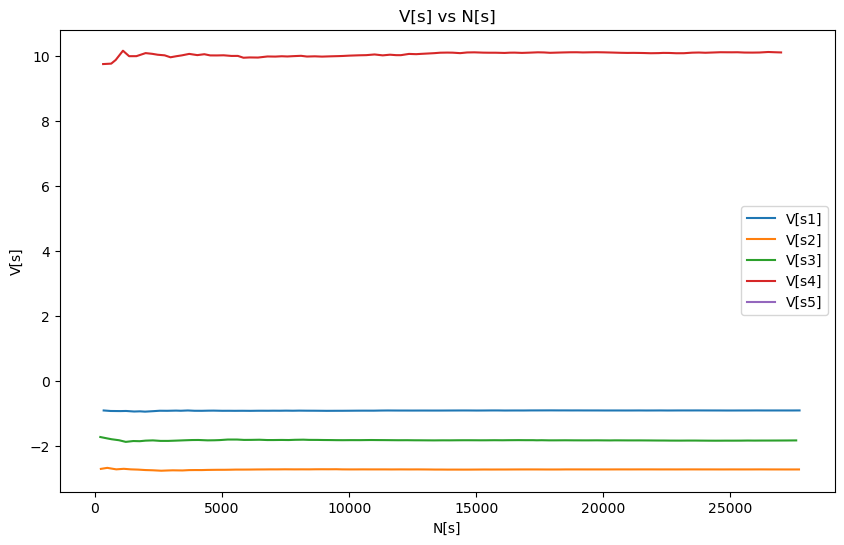

In [17]:
plot_Vs(MDP, Pi_1)

### 6.占用量度
状态访问分布和占用度量是强化学习中两个相关的概念，常用于描述一个策略在环境中的行为。以下是这两个概念的定义和描述：

1. **状态访问分布** (State Visitation Distribution):
   
状态访问分布描述了在给定策略下，一个状态被访问的频率或概率。这通常取决于策略本身以及初始状态分布。例如，考虑一个迷宫问题，某些状态可能经常被访问（例如，迷宫的入口或者交叉点），而其他状态可能很少或从不被访问。状态访问分布会反映出这种差异。
   
具体地说，状态访问分布 $d(s)$ 可以通过以下公式定义：
   
$$d(s) = \sum_{s', a} P(s' \to s | a) \pi(a|s') d(s')$$
   
其中，$P(s' \to s | a)$ 是从状态 $s'$ 在采取动作 $a$ 后转移到状态 $s$ 的概率，而 $\pi(a|s')$ 是在状态 $s'$ 下采取动作 $a$ 的概率。

2. **占用度量** (Occupancy Measure):

占用度量描述了在给定策略下，一个状态-动作对 (state-action pair) 被访问的频率或概率。这可以视为状态访问分布的扩展，因为它不仅考虑了状态，还考虑了在该状态下采取的动作。
   
具体地说，占用度量 $\rho(s, a)$ 可以通过以下公式定义：

$$\rho(s, a) = d(s) \pi(a|s)$$
   
其中，$d(s)$ 是状态 $s$ 的访问分布，而 $\pi(a|s)$ 是在状态 $s$ 下采取动作 $a$ 的概率。

这两个概念在强化学习中尤为重要，特别是在逆强化学习（Inverse Reinforcement Learning，IRL）中，其中我们试图从观察到的行为中推断出奖励函数。状态访问分布和占用度量提供了关于策略在环境中行为的关键信息，这有助于我们更好地理解和建模该策略。

---

然后就可以定义一个策略的状态访问分布（state visitation distribution）：
$$
\nu^{\pi}(s)=(1-\gamma) \sum_{t=0}^{\infty} \gamma^{t} P_{t}^{\pi}(s)
$$
其中， $1-\gamma$ 是用来使得概率加和为 1 的归一化因子。状态访问概率表示一个策略和 MDP 交互会访问到的状态的分布。需要注意的是，理论上在计算该分布时需要交互到无穷步之后，但实际上智能体和 MDP 的交互在一个序列中是有限的。不过我们仍然可以用以上公式来表达状态访问概率的思想，状态访问概率有如下性质:
$$
\nu^{\pi}\left(s^{\prime}\right)=(1-\gamma) \nu_{0}\left(s^{\prime}\right)+\gamma \int P\left(s^{\prime} \mid s, a\right) \pi(a \mid s) \nu^{\pi}(s) d s d a
$$
$$
\rho^{\pi}(s, a)=(1-\gamma) \sum_{t=0}^{\infty} \gamma^{t} P_{t}^{\pi}(s) \pi(a \mid s)\
$$
它表示动作状态对 $(s, a)$ 被访问到的概率。二者之间存在如下关系:
$$
\rho^{\pi}(s, a)=\nu^{\pi}(s) \pi(a \mid s)
$$
进一步得出如下两个定理：
- 定理 1: 智能体分别以策略 $\pi_{1}$ 和 $\pi_{2}$ 和同一个 MDP 交互得到的占用度量 $\rho^{\pi_{1}}$ 和 $\rho^{\pi_{2}}$ 满足
$$\rho^{\pi_{1}}=\rho^{\pi_{2}} \Longleftrightarrow \pi_{1}=\pi_{2}$$

- 定理 2：给定一合法占用度量 $\rho$ ，可生成该占用度量的唯一策略是
$$\pi_{\rho}=\frac{\rho(s, a)}{\sum_{a^{\prime}} \rho\left(s, a^{\prime}\right)}$$

#### 代码估计
注意：以上提到的“合法”占用度量是指存在一个策略使智能体与 MDP 交互产生的状态动作对被访问到的概率。

接下来我们编写代码来近似估计占用度量。这里我们采用近似估计，即设置一个较大的采样轨迹长度的最大值，然后采样很多次，用状态动作对出现的频率估计实际概率。
```python
def occupancy(episodes, s, a, timestep_max, gamma):
    ''' 计算状态动作对（s,a）出现的频率,以此来估算策略的占用度量 '''
    rho = 0
    total_times = np.zeros(timestep_max)  # 记录每个时间步t各被经历过几次
    occur_times = np.zeros(timestep_max)  # 记录(s_t,a_t)=(s,a)的次数
    for episode in episodes:
        for i in range(len(episode)):
            (s_opt, a_opt, r, s_next) = episode[i]
            total_times[i] += 1
            if s == s_opt and a == a_opt:
                occur_times[i] += 1
    for i in reversed(range(timestep_max)):
        if total_times[i]:
            rho += gamma**i * occur_times[i] / total_times[i]
    return (1 - gamma) * rho


gamma = 0.5
timestep_max = 1000

episodes_1 = sample(MDP, Pi_1, timestep_max, 1000)
episodes_2 = sample(MDP, Pi_2, timestep_max, 1000)
rho_1 = occupancy(episodes_1, "s4", "概率前往", timestep_max, gamma)
rho_2 = occupancy(episodes_2, "s4", "概率前往", timestep_max, gamma)
print(rho_1, rho_2)
```

您给出的状态访问分布和占用度量的定义是在考虑了折扣因子 $ \gamma $ 的情况下的定义。在您给出的定义中，折扣因子 $ \gamma $ 被用来对未来的状态和动作进行折扣，这样使得近期的状态和动作比远期的更重要。

我之前给出的定义是更为通用的定义，没有明确包括折扣因子。但两者的核心思想是相同的：描述在给定策略下，状态或状态-动作对被访问的分布。

现在，让我们对比一下两个定义：

1. **状态访问分布**:
   - 我给出的定义主要基于状态转移概率和策略的递归关系来定义。
   - 您给出的定义是考虑了时间和折扣因子的，表达了在无限时间内，状态被访问的期望频率。

2. **占用度量**:
   - 我给出的定义是状态访问分布和在给定状态下采取特定动作的概率的乘积。
   - 您给出的定义同样是基于时间和折扣因子，表达了在无限时间内，状态-动作对被访问的期望频率。

您给出的两个定理是基于占用度量和状态访问分布的关系的。这两个定理描述了占用度量、策略和状态访问分布之间的一些重要性质。

总之，虽然两种定义在形式上有所不同，但它们都是为了描述同一核心概念。您给出的定义在某些特定的研究背景和应用中可能更为合适，特别是当考虑时间和折扣因子的影响时。
